In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise
# set up hyperparameters
# max_features = 50000
maxlen = 500
batch_size = 128
VOCAB_size = 4000
INPUT_SIZE=500

dataset = DataSet(VOCAB_size, maxlen=INPUT_SIZE, train_portion=0.7)
with open('l2wd/dataset_4000_70.pkl', 'wb') as f:
    pickle.dump(dataset, f)
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


class CustomCuDNNLSTM(CuDNNLSTM):
    def __init__(self, units, **kwargs):
        super(CustomCuDNNLSTM, self).__init__(units, **kwargs)

    def build(self, input_shape):
        super(CustomCuDNNLSTM, self).build(input_shape)

    def get_config(self):
        config = super(CustomCuDNNLSTM, self).get_config()
        return config


model_s = tf.keras.Sequential()


model_s.add(Embedding(VOCAB_size, output_dim=32, input_length=500,weights=weights,trainable=False))


model_s.add(CustomCuDNNLSTM(60,kernel_initializer=tf.constant_initializer(value=1e-7),
                            recurrent_initializer=tf.constant_initializer(value=1e-7),
                            bias_initializer='zeros',unit_forget_bias=False))


model_s.add(Dense(1, activation='sigmoid',weights=weights2,trainable=False))


opt = tf.keras.optimizers.Adam(learning_rate=0.0008)
model_s.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#train step
def custom_train_step(model, inputs, targets, l2_strength):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = tf.keras.losses.binary_crossentropy(targets, predictions)

        # Calculate L2 regularization term for LSTM kernel and recurrent weights
        if l2_strength > 0.0:
            lstm_weights = model.layers[1].trainable_weights  # Access the LSTM layer's weights
            l2_reg = tf.add_n([tf.nn.l2_loss(w) for i,w in enumerate(lstm_weights) if i==1])
            loss += l2_strength * l2_reg

    # Compute gradients
    trainable_weights = model.trainable_variables
    gradients = tape.gradient(loss, trainable_weights)



    # non update kernel and bias
    for i, weight in enumerate(trainable_weights):
        if i==2:
            gradients[i] = tf.zeros_like(weight)


    opt.apply_gradients(zip(gradients, trainable_weights))
    return loss

def custom_train_loop(model, x_train, y_train, x_test, y_test, epochs, batch_size,l2_strength):
    num_batches = len(x_train) // batch_size
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in range(num_batches):
            batch_inputs = x_train[batch * batch_size : (batch + 1) * batch_size]
            batch_targets = y_train[batch * batch_size : (batch + 1) * batch_size]

            # Reshape batch_targets to (batch_size, 1) to match the model output shape
            batch_targets = batch_targets.reshape(-1, 1)

            loss= custom_train_step(model, batch_inputs, batch_targets,l2_strength)
            epoch_loss += tf.reduce_mean(loss)

        avg_loss = epoch_loss / num_batches
        print("Epoch {}: Loss: {:.4f}".format(epoch + 1, avg_loss.numpy()))


        # Reshape y_test to (batch_size, 1) to match the model output shape
        y_test_reshaped = y_test.reshape(-1, 1)
        val_loss,val_accuracy = model.evaluate(x_test, y_test_reshaped, verbose=0)

        print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
        print("Validation Loss: {:.4f}".format(val_loss))

        
        path='l2wd'+'/'+'weight.'+str(epoch+1)+'.txt'
        np.savetxt(path,model.layers[1].get_weights()[0])
        path1='l2wd'+'/'+'weight_re.'+str(epoch+1)+'.txt'
        np.savetxt(path1,model.layers[1].get_weights()[1])
        path2='l2wd'+'/'+'loss.'+str(epoch+1)+'.txt'
        np.savetxt(path2,[avg_loss.numpy(),val_loss])
        path3='l2wd'+'/'+'deweights.'+str(epoch+1)+'.txt'
        np.savetxt(path3,model.layers[1].get_weights()[2])

#train
l2_strength = 0.0
custom_train_loop(model_s, x_train, y_train, x_test, y_test, epochs=1000, batch_size=batch_size,l2_strength=l2_strength)


x_train shape: (35000, 500)
x_test shape: (15000, 500)
Epoch 1: Loss: 0.6862
Validation Accuracy: 50.67%
Validation Loss: 0.6976
Epoch 2: Loss: 0.6700
Validation Accuracy: 50.79%
Validation Loss: 0.7043
Epoch 3: Loss: 0.6622
Validation Accuracy: 50.97%
Validation Loss: 0.7157
Epoch 4: Loss: 0.6537
Validation Accuracy: 51.53%
Validation Loss: 0.7132


KeyboardInterrupt: 

In [25]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise
path='LSTM/'+'weights.112'+'.hdf5'
model=load_model(path)
weights = model.layers[0].get_weights()
weights3= model.layers[1].get_weights()[0]
weights2= model.layers[2].get_weights()
weights4= model.layers[1].get_weights()[2]
weights5= model.layers[1].get_weights()[1]
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import numpy as np
import math
import numpy
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import models, Model
import numpy as np

class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        """
        :param num_words: Size of vocabulary, all words out-of-vocabulary will be marked as [unk]
        :param seed: Seed for randomly shuffling dataset
        :param maxlen: Maximum length of review, reviews longer than maxlen will be truncated, reviews shorter than
        maxlen will be padded to maxlen
        :param train_portion: Portion of dataset to allocate to training data, test data will be 1-train_portion
        :param long_first: Sort reviews by length
        """
        # retrieve IMDb data, x is a sequence containing movie review,
        # y is a label indicating if it is positive or negative sentiment
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)

        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)

            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)

        self.total_length = [len(x) for x in self.x_train]
        temp = [len(x) for x in self.x_test]
        self.total_length.extend(temp)

        # padding sequences to all be of the same length
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')

        self.split_data(train_portion)

        self.word_index = imdb.get_word_index()
        self.word_to_index = {word:id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i:word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}

        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id

        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    # splits data into ratio train:test -> (train_portion:1-train_portion)
    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        self.train_length, self.test_length = self.total_length[:math.floor(train_portion * len(x))], \
                                              self.total_length[math.floor(train_portion * len(x)):]
        self.x_train, self.x_test = x[:math.floor(train_portion * len(x))], \
                                    x[math.floor(train_portion * len(x)):]
        self.y_train, self.y_test = y[:math.floor(train_portion * len(y))], \
                                    y[math.floor(train_portion * len(y)):]
        return None

2023-07-30 14:52:47.532443: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 14:52:47.534908: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 14:52:47.536784: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [53]:
path='LSTM/'+'weights.112'+'.hdf5'
model=load_model(path)


2023-07-29 09:28:38.940937: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-29 09:28:38.943445: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-29 09:28:38.945338: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [60]:
trainable_weights=model.trainable_weights
trainable_weights
for i, weight in enumerate(trainable_weights):
        if i==2:
            print(weight)

<tf.Variable 'lstm/lstm_cell_7/recurrent_kernel:0' shape=(60, 240) dtype=float32, numpy=
array([[-0.21544169, -0.16896819, -0.04402455, ..., -0.03361932,
         0.11543127, -0.09777789],
       [-0.22885205,  0.08653583, -0.03586553, ..., -0.02642412,
         0.26444066, -0.17803846],
       [ 0.10028367,  0.24301484, -0.07605659, ...,  0.06879387,
        -0.02610794,  0.26474047],
       ...,
       [-0.06966768, -0.02885648,  0.06049519, ...,  0.0257703 ,
        -0.09961962, -0.18842945],
       [-0.03316697, -0.09689174, -0.0525579 , ...,  0.08111709,
        -0.07561488,  0.03760759],
       [ 0.22097662,  0.09180017,  0.07141487, ...,  0.08621624,
        -0.00288599,  0.17911991]], dtype=float32)>


In [68]:
lstm_weights = model.layers[1].trainable_weights
for i, weight in enumerate(lstm_weights):
        if i==0 or i==1:
            print(weight)

<tf.Variable 'lstm/lstm_cell_7/kernel:0' shape=(32, 240) dtype=float32, numpy=
array([[ 0.01642605, -0.20805743,  0.14795321, ..., -0.13192886,
         0.38897893,  0.14964229],
       [ 0.03620276,  0.04733484, -0.07839603, ...,  0.06010227,
        -0.24708197,  0.5569279 ],
       [-0.20708807, -0.17189084,  0.04429737, ..., -0.06285817,
        -0.18195543,  0.5504199 ],
       ...,
       [-0.52702075, -0.56992316, -0.33549082, ..., -0.19349834,
         0.14639863,  0.15844297],
       [-0.47012413, -0.5603828 , -0.24893093, ..., -0.15815496,
        -0.11735667,  0.17936431],
       [ 0.03618475,  0.02570797, -0.25163168, ..., -0.11939759,
         0.29491085, -0.03093484]], dtype=float32)>
<tf.Variable 'lstm/lstm_cell_7/recurrent_kernel:0' shape=(60, 240) dtype=float32, numpy=
array([[-0.21544169, -0.16896819, -0.04402455, ..., -0.03361932,
         0.11543127, -0.09777789],
       [-0.22885205,  0.08653583, -0.03586553, ..., -0.02642412,
         0.26444066, -0.17803846],
   

0.2872662842273712

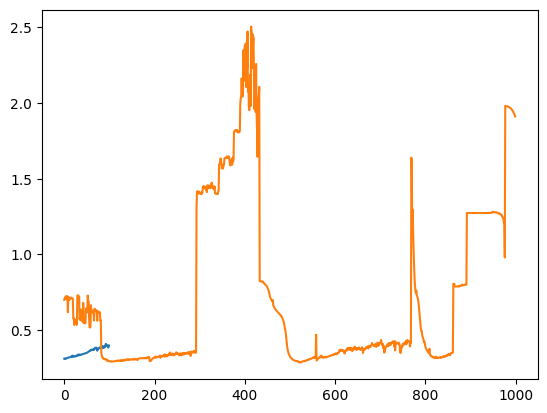

In [37]:
l=[]
for i in range(60,160):
    path='innine/loss.'+str(i)+'.txt'
    with open(path) as f:
        for line in f.readlines():
            line=np.float64(line.strip('\n'))
            l.append(line)
l=l[1::2]
ll=[]
for i in range(1000):
    path='insith/loss.'+str(i+1)+'.txt'
    with open(path) as f:
        for line in f.readlines():
            line=np.float64(line.strip('\n'))
            ll.append(line)
ll=ll[1::2]
plt.plot(l)
plt.plot(ll)
min(ll)

In [46]:
np.savetxt('intwee/loss_0.0005.txt',l)

In [38]:
a=[]
path='innine/weight.'+str(57)+'.txt'
with open(path) as f:
        for line in f.readlines():
                line=np.float64(line.strip('\n').split())
                a.append(line)
path11='innine/weight_re.'+str(57)+'.txt'
b=[]
with open(path11) as f:
        for line in f.readlines():
                line=np.float64(line.strip('\n').split())
                b.append(line)

In [25]:
weights4=np.array(weights4)

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [22]:
path='LSTM/'+'weights.01'+'.hdf5'
model=load_model(path)
weights = model.layers[0].get_weights()
weights3= model.layers[1].get_weights()[0]
weights2= model.layers[2].get_weights()
weights4= model.layers[1].get_weights()[1]
weights5= model.layers[1].get_weights()[2]
weights5=weights5.tolist()+np.zeros((240,)).tolist()
weights5=np.array(weights5)
len(weights5)

2023-07-28 08:54:05.000564: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 08:54:05.002879: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 08:54:05.004792: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

480